<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_pos_rate_compare_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
wb = gc.open_by_url(url)

In [0]:
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [15]:
full_df = pd.DataFrame(data)
full_df.head()

,0,1,2,3,4,5,6,7
0,Date,State,Positive,Negative,Pending,Hospitalized,Death,Total
1,20200330,AK,114,"3,540",,7,3,"3,654"
2,20200330,AL,859,"5,694",,,6,"6,553"
3,20200330,AR,473,"5,262",,62,7,"5,735"
4,20200330,AS,,,,,0,0


In [0]:
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':
      df[c] = pd.to_datetime(df[c])
    elif c=='State':
      pass
    else:
      df[c] = pd.to_numeric(df[c].str.replace(',',''))
  return(df)

In [0]:
def set_first_row_as_header(df):
  new_header = df.iloc[0] #grab the first row for the header
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header
  return(df)
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['posrate'] = full_df.Positive / (full_df.Positive+full_df.Negative.fillna(0))

states = ['MA', 'NY', 'WA', 'CA', 'IL', 'LA', 'FL', 'NC', 
          'NJ', 'OH', 'PA', 'TX', 'TN', 'WI', 'MN', 'MI']


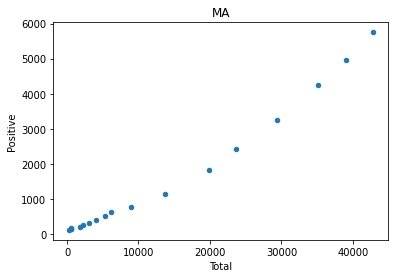

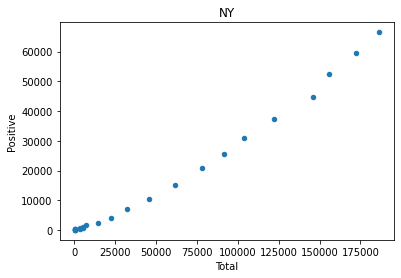

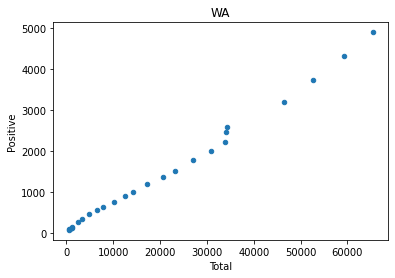

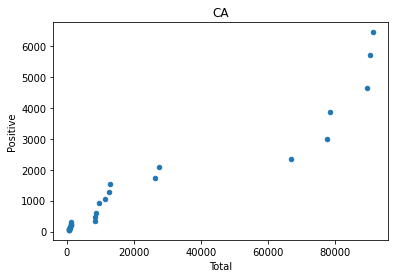

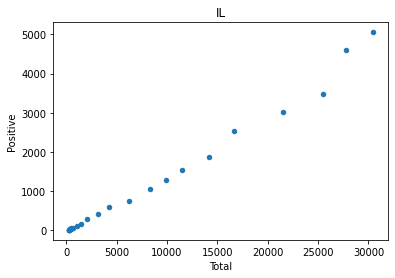

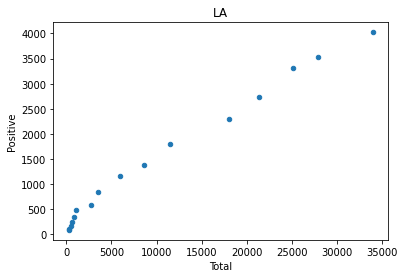

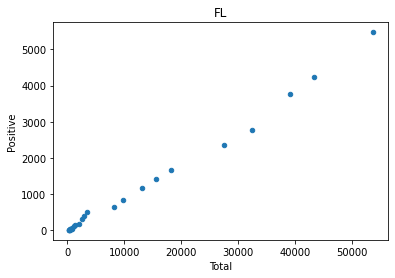

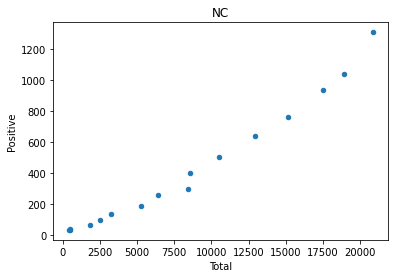

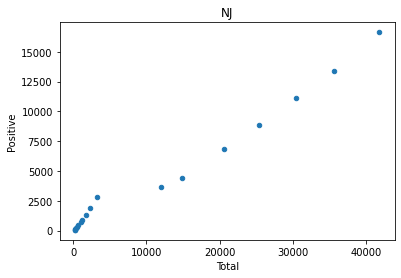

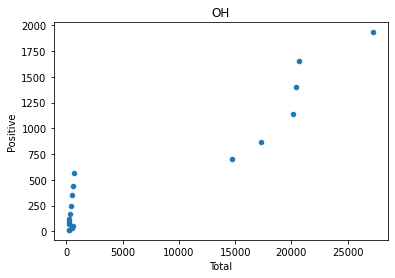

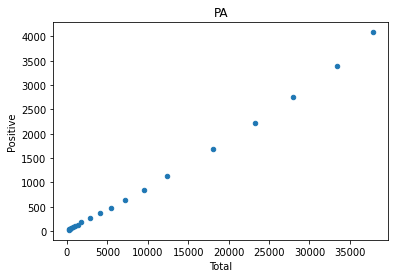

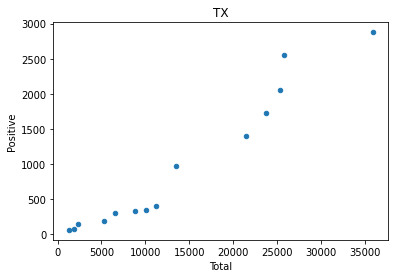

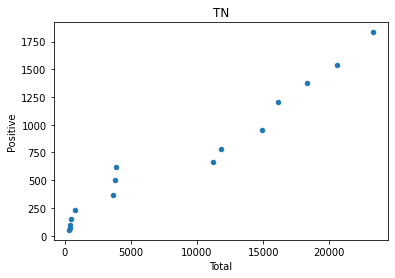

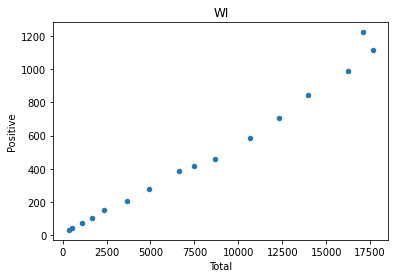

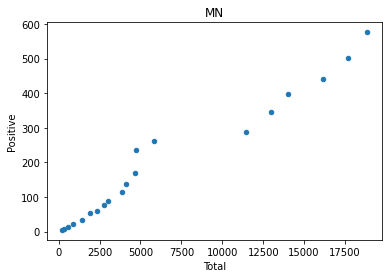

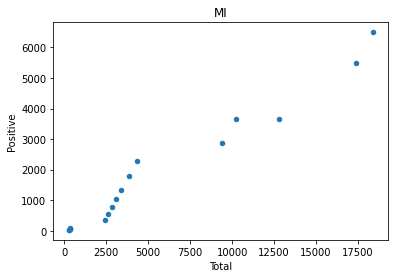

In [18]:
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Total','Positive']].plot(kind='scatter', x='Total', y='Positive', title=state)
  plt.show()

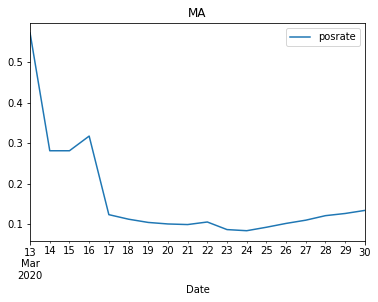

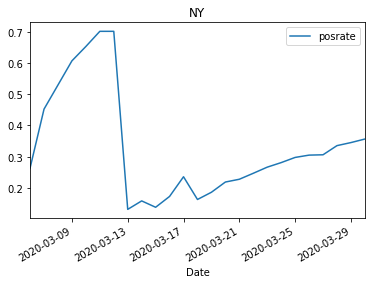

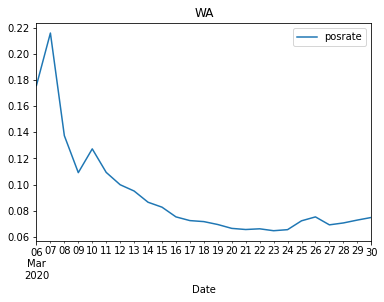

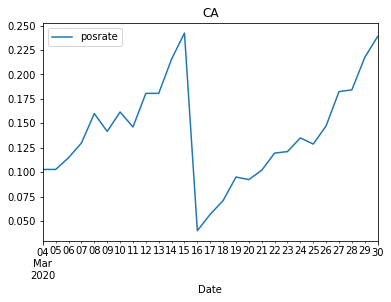

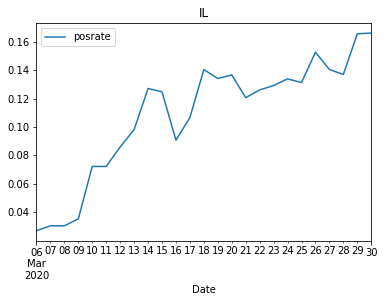

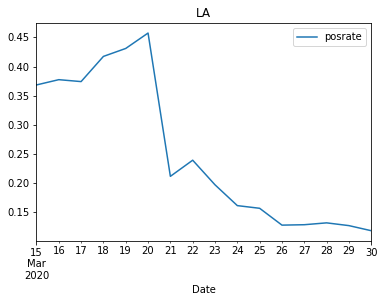

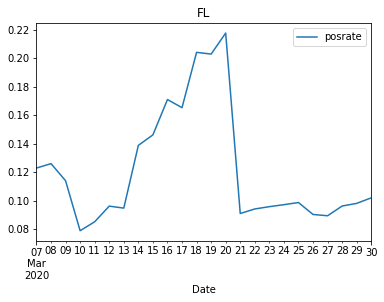

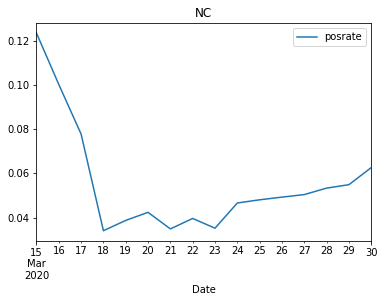

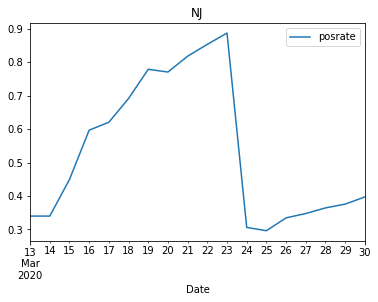

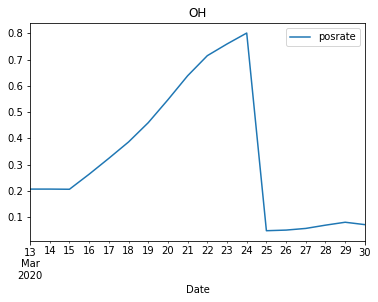

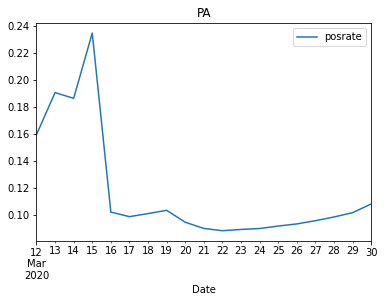

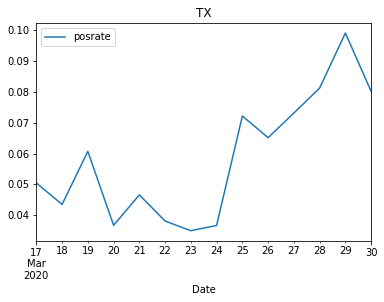

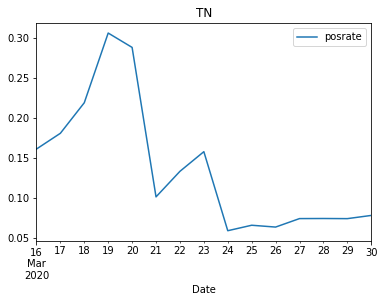

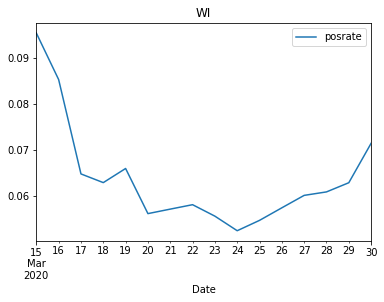

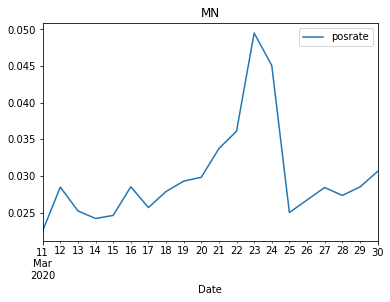

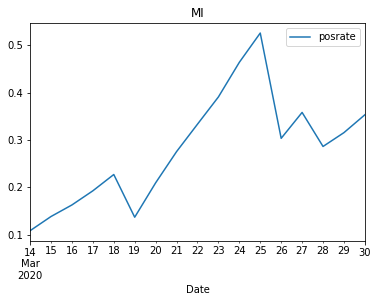

In [19]:
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Date','posrate']].set_index('Date').plot(y='posrate', title=state)
  plt.show()

In [20]:
df = full_df[full_df.Date>'2020-03-16'][['Date', 'posrate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.posrate.agg(['mean', 'std']).sort_values('std')

,mean,std
State,,
WA,0.069745,0.003605
WI,0.060133,0.005131
PA,0.095757,0.006094
MN,0.031694,0.007290
NC,0.047705,0.012111
MA,0.107659,0.014966
IL,0.137178,0.016048
TX,0.058495,0.020432
FL,0.124412,0.049223
